# Calculating Correction Factors

#### Import Modules

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from sklearn import linear_model

import plotly.offline as py
import plotly.graph_objects as go

from sensors.pa_datafile import PAfiles
from sensors.TCEQ_pm_datafile import TCEQfile

import matplotlib.pyplot as plt
import numpy as np

#### Import data

In [3]:
pa_files = PAfiles('data/ytd', keepOutliers=False)
tceq = TCEQfile('data/ytd/tceq.csv')
tceq_trh = pd.read_csv('data/ytd/tceq_trh.csv')#.set_index('Time')

tceq_trh['Time'] = pd.to_datetime(tceq_trh['Time'], format='%Y-%m-%d %H:%M:%S')
tceq_trh = tceq_trh.set_index('Time').tz_localize('US/Central', nonexistent='shift_forward')

Loading data from '.dae3cde0_import_pa_files.cache' ... Done


#### Take data from all sensors to calculate one average for PurpleAir PM2.5

In [4]:
def plot_avg_pm2(param='PM2.5_ATM_ug/m3', freq=None):
    
    # A list of series with PM data (non rolling)
    combined_data = [file[:].resample(freq).mean()[param].rename(file.sensorname) 
                      for file in pa_files if file[param] is not None]
    
    
    combined_data =  pd.concat(combined_data, axis=1) #columns = sensors, rows = pm values
    avg_values = combined_data.mean(axis=1)  #average all sensors
    
    return avg_values #panda series

# Create column with the average pm across all sensors
pa_avg = plot_avg_pm2(freq='H').rename('PM2.5_ATM_ug/m3')
pa_avg.index.name = 'Time'

#### Creating dataframe with all predictor variables

In [5]:
# Combine PA data with tceq trh data in dataframe
# df = pa_avg.append(tceq_trh).rename(columns={0:'PurplePM2.5'})
df = pd.DataFrame(pa_avg).merge(tceq_trh, how='inner', on='Time')
df = df.merge(tceq.data.tz_convert('US/Central'), how='inner', on='Time').dropna(how='any')

#### Linear Regression

In [7]:
pm_vector = df['PM2.5_ATM_ug/m3']
X = df[['PM2.5_ATM_ug/m3','Relative Humidity(%)', 'Temperature(F)']] ## X usually means our input variables (or independent variables)
y = df['PM2.5'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  PM2.5   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     1761.
Date:                Tue, 12 May 2020   Prob (F-statistic):               0.00
Time:                        14:44:07   Log-Likelihood:                -6395.4
No. Observations:                2503   AIC:                         1.280e+04
Df Residuals:                    2499   BIC:                         1.282e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.4898 

#### Quadratic Regression

In [6]:
# Quadratic regression
data = {'temp':df['Temperature(F)'],'r':df['Relative Humidity(%)'],'purple':df['PM2.5_ATM_ug/m3'],'tceq':df['PM2.5']}
dewpoint = ((data['temp']-32)*5/9+((100-data['r'])/5))*9/5+32
data['dp']=dewpoint
# I() is used to get it to do quadratic regression properly
model = smf.ols(formula='tceq ~ temp + r + purple + I(r**2) + I(temp**2) + I(purple**2) + I(r*temp) + I(purple*temp) + I(r*purple)', data=data).fit()
# model = smf.ols(formula='tceq ~ temp + r + purple + dp', data=data).fit()

data1 = {'temp':df['Temperature(F)'],'r':df['Relative Humidity(%)'],'purple':df['PM2.5_ATM_ug/m3']}
predictions = model.predict(data)
# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   tceq   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     647.5
Date:                Tue, 12 May 2020   Prob (F-statistic):               0.00
Time:                        14:43:50   Log-Likelihood:                -6308.6
No. Observations:                2503   AIC:                         1.264e+04
Df Residuals:                    2493   BIC:                         1.270e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           14.1121      3.165  

#### Correlation Plots Between Measured/Predicted vs. Actual

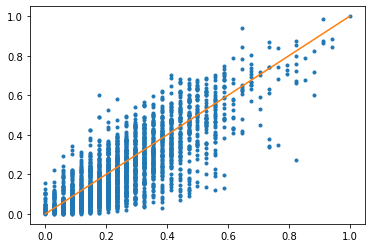

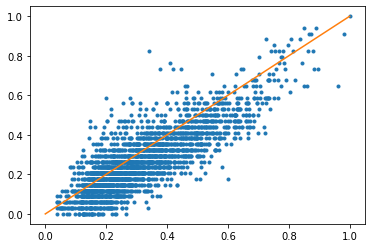

In [8]:
plt.figure()
plt.plot(abs(y/np.max(y)),abs(pm_vector/np.max(pm_vector)),'.')
a = np.linspace(0,1,100)
plt.plot(a,a)

plt.figure()
plt.plot(abs(predictions/np.max(predictions)),abs(y/np.max(y)),'.')
a = np.linspace(0,1,100)
plt.plot(a,a)

#### R-squared Values

In [10]:
r2_original = np.corrcoef(pm_vector,y)[0,1]**2
print(r2_original)
r2_predict = np.corrcoef(predictions,y)[0,1]**2

0.6423213665652275


#### Interactive Plot

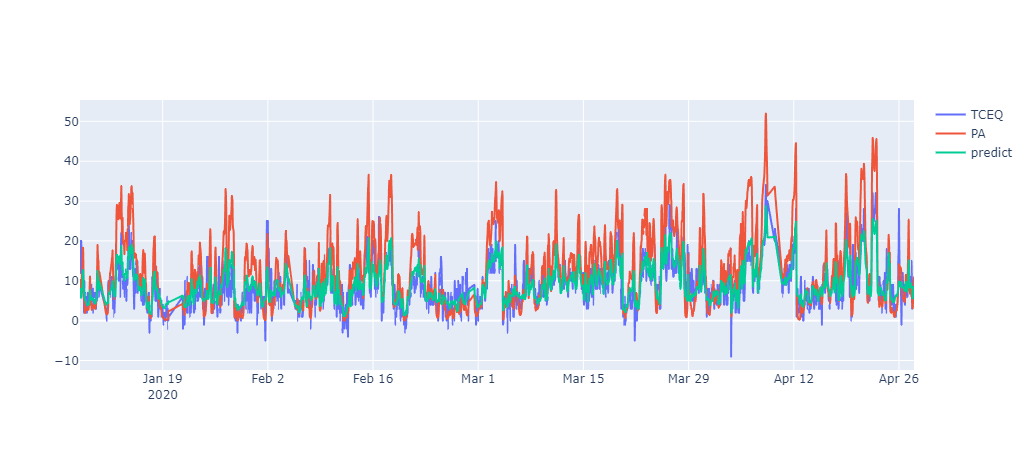

In [13]:
fig = go.Figure()
ya=y
fig.add_trace(go.Scattergl(x=df.index, y=ya,
                           mode='lines', name='TCEQ'))
fig.add_trace(go.Scattergl(x=df.index, y=pm_vector,
                           mode='lines', name='PA'))
fig.add_trace(go.Scattergl(x=df.index, y=predictions,
                           mode='lines', name='predict'))
py.iplot(fig)

#### Static Plot

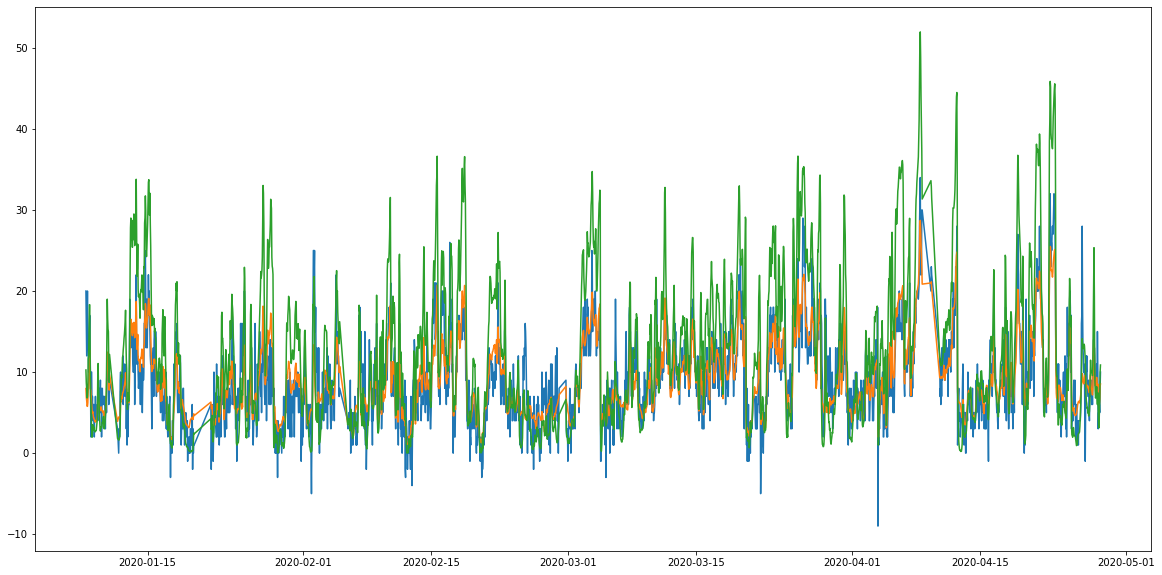

In [15]:
plt.figure(figsize=(20, 10))
plt.plot_date(df.index, y, '-')
plt.plot_date(df.index, predictions,'-')
plt.plot_date(df.index, pm_vector, '-')

plt.savefig('temp-fds.svg')